In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle


In [4]:
#######
DATA_FNAME = '/data/delon/LensQuEst/N0_Ni.pkl'
mean_field_file = 'mask_simple400x400_point_sources_bigger.pkl'
import warnings
warnings.filterwarnings("ignore")
#####

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 400 # 1200
nY = 400 #1200

# map dimensions in degrees
sizeX = 10.
sizeY = 10.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [101]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1., noise=1., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.flensedTT(l) + cmb.fdetectorNoise(l)
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [102]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [103]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.ftotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) #+ fNqCmbFG_fft(l)

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [104]:
#https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [105]:
from scipy.ndimage import gaussian_filter 
from scipy.fft import fft2

mask = rgb2gray(plt.imread('mask_simple%dx%d.png'%(nX, nY)))
apodized_mask = gaussian_filter(mask, 3)
point_sources = rgb2gray(plt.imread('point_sources_bigger.png'))
point_sources = gaussian_filter(point_sources, 1.5) 
apodized_mask += point_sources
nPos = np.where(apodized_mask>1)
apodized_mask[nPos] = 1
mask = 1-mask
apodized_mask = 1 - apodized_mask

for a in apodized_mask:
    for b in a:
        assert(b<=1 and b>=0)

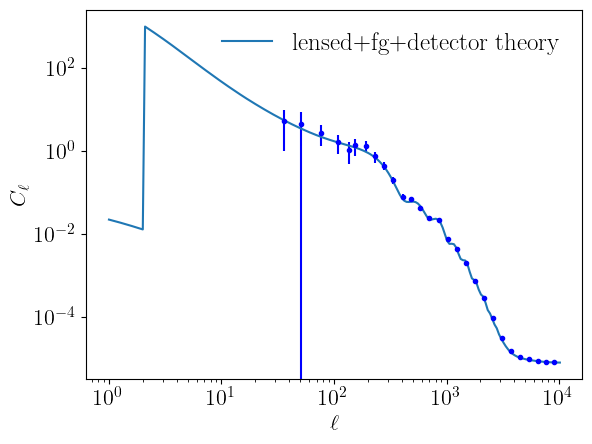

(array([1.10134950e+00, 1.32459194e+00, 1.59308540e+00, 1.91600222e+00,
        2.30437396e+00, 2.77146825e+00, 3.33324210e+00, 4.00888694e+00,
        4.82148431e+00, 5.79879436e+00, 6.97420418e+00, 8.38786839e+00,
        1.00880809e+01, 1.21329248e+01, 1.45922566e+01, 1.75500924e+01,
        2.11074786e+01, 2.53859434e+01, 3.05316487e+01, 3.60000000e+01,
        4.41635684e+01, 5.09116882e+01, 6.38819341e+01, 7.68562555e+01,
        9.24042521e+01, 1.09223860e+02, 1.35885626e+02, 1.54318492e+02,
        1.91270149e+02, 2.30849319e+02, 2.75913978e+02, 3.37767020e+02,
        4.09214632e+02, 4.87121784e+02, 5.84541819e+02, 7.05780752e+02,
        8.49567654e+02, 1.02071625e+03, 1.22784902e+03, 1.47725961e+03,
        1.77543811e+03, 2.13554713e+03, 2.56878450e+03, 3.08962009e+03,
        3.71631490e+03, 4.46999817e+03, 5.37515810e+03, 6.46451210e+03,
        7.62336414e+03, 9.02805575e+03]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00

In [96]:
cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
cmb0 = baseMap.inverseFourier(cmb0Fourier)

kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
kCmb = baseMap.inverseFourier(kCmbFourier)

lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
lensedCmbFourier = baseMap.fourier(lensedCmb)

fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
lensedCmbFourier = lensedCmbFourier + fgFourier
lensedCmb = baseMap.inverseFourier(lensedCmbFourier)

noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
totalCmbFourier = lensedCmbFourier + noiseFourier
totalCmb = baseMap.inverseFourier(totalCmbFourier)

baseMap.powerSpectrum(totalCmbFourier,theory=[cmb.ftotal], 
                                      theory_l=['lensed+fg+detector'],
                                      plot=True, save=False)

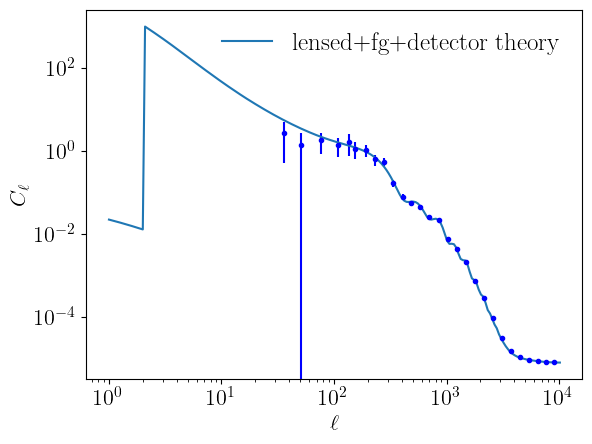

(array([1.10134950e+00, 1.32459194e+00, 1.59308540e+00, 1.91600222e+00,
        2.30437396e+00, 2.77146825e+00, 3.33324210e+00, 4.00888694e+00,
        4.82148431e+00, 5.79879436e+00, 6.97420418e+00, 8.38786839e+00,
        1.00880809e+01, 1.21329248e+01, 1.45922566e+01, 1.75500924e+01,
        2.11074786e+01, 2.53859434e+01, 3.05316487e+01, 3.60000000e+01,
        4.41635684e+01, 5.09116882e+01, 6.38819341e+01, 7.68562555e+01,
        9.24042521e+01, 1.09223860e+02, 1.35885626e+02, 1.54318492e+02,
        1.91270149e+02, 2.30849319e+02, 2.75913978e+02, 3.37767020e+02,
        4.09214632e+02, 4.87121784e+02, 5.84541819e+02, 7.05780752e+02,
        8.49567654e+02, 1.02071625e+03, 1.22784902e+03, 1.47725961e+03,
        1.77543811e+03, 2.13554713e+03, 2.56878450e+03, 3.08962009e+03,
        3.71631490e+03, 4.46999817e+03, 5.37515810e+03, 6.46451210e+03,
        7.62336414e+03, 9.02805575e+03]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00

In [97]:
totalCmbFourier = baseMap.genGRF(cmb.ftotal)
baseMap.powerSpectrum(totalCmbFourier,theory=[cmb.ftotal], 
                                      theory_l=['lensed+fg+detector'],
                                      plot=True, save=False)

In [106]:
from tqdm import trange,tqdm 
import pickle

from itertools import product

N_RUNS = 3
poss = list(product([True, False], range(N_RUNS)))

data = {}

MASKED = False


for LENSED, run_n in tqdm(poss):
    post_fix = '%d_%d'%(MASKED,LENSED)

    mean_field = pickle.load(open(mean_field_file, 'rb'))
    if(not MASKED):
        mean_field = np.zeros_like(mean_field)

    totalCmbFourier, totalCmb = 0, 0
    kCmbFourier, kCmb = 0, 0
    if(not LENSED):
        print(LENSED, run_n, post_fix)
        totalCmbFourier = baseMap.genGRF(cmb.ftotal)
        totalCmb = baseMap.inverseFourier(totalCmbFourier)
    elif(LENSED):
        print(LENSED, run_n, post_fix)
        cmb0Fourier = baseMap.genGRF(cmb.funlensedTT, test=False)
        cmb0 = baseMap.inverseFourier(cmb0Fourier)

        kCmbFourier = baseMap.genGRF(p2d_cmblens.fPinterp, test=False)
        kCmb = baseMap.inverseFourier(kCmbFourier)

        lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
        lensedCmbFourier = baseMap.fourier(lensedCmb)

        fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
        lensedCmbFourier = lensedCmbFourier + fgFourier
        lensedCmb = baseMap.inverseFourier(lensedCmbFourier)

        noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
        totalCmbFourier = lensedCmbFourier + noiseFourier
        totalCmb = baseMap.inverseFourier(totalCmbFourier)

    if(MASKED):
        totalCmb = apodized_mask*totalCmb
        totalCmbFourier = baseMap.fourier(totalMaskedCmb)

    c_Data = {}
    
    #kappa
    c_Data['k'+post_fix] = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, 
                                                           cmb.fCtotal, 
                                                           lMin=lMin, lMax=lMax,
                                                           dataFourier=totalCmbFourier)

    #Nhat
    c_Data['sqrtNhat'+post_fix] = baseMap.computeQuadEstKappaAutoCorrectionMap(cmb.funlensedTT, 
                                                                               cmb.fCtotal, 
                                                                               lMin=lMin, lMax=lMax, 
                                                                               dataFourier=totalCmbFourier)

    #kappaR
    totalCmbFourierRandomized = baseMap.randomizePhases(totalCmbFourier)
    totalCmbRandomized = baseMap.inverseFourier(totalCmb)
    c_Data['kR'+post_fix] = baseMap.computeQuadEstKappaNorm(cmb.funlensedTT, 
                                                            cmb.fCtotal, 
                                                            lMin=lMin, lMax=lMax,
                                                            dataFourier=totalCmbFourierRandomized)

    c_Data['Nhat'+post_fix] = [0,0,0]
    c_Data['kRkR'+post_fix] = [0,0,0]
    c_Data['kk'+post_fix]   = [0,0,0]
    
    c_Data['kk'+post_fix][0],   c_Data['kk'+post_fix][1],   c_Data['kk'+post_fix][2]   = baseMap.powerSpectrum(dataFourier=c_Data['k'+post_fix])
    c_Data['Nhat'+post_fix][0], c_Data['Nhat'+post_fix][1], c_Data['Nhat'+post_fix][2] = baseMap.powerSpectrum(dataFourier=c_Data['sqrtNhat'+post_fix])
    c_Data['kRkR'+post_fix][0], c_Data['kRkR'+post_fix][1], c_Data['kRkR'+post_fix][2] = baseMap.powerSpectrum(dataFourier=c_Data['kR'+post_fix])

    if(LENSED):
        c_Data['kTkT'+post_fix]   = [0,0,0]
        c_Data['kTkT'+post_fix][0], c_Data['kTkT'+post_fix][1], c_Data['kTkT'+post_fix][2] = baseMap.powerSpectrum(dataFourier=kCmbFourier)
    
    for key in c_Data:
        if(key not in data.keys()):
            data[key] = np.array([c_Data[key]])
        else:
            data[key] = np.vstack((np.array([c_Data[key]]), data[key]))  
            
#     f = open(DATA_FNAME, 'wb') 
#     pickle.dump(data, f)
#     f.close()

  0%|          | 0/6 [00:00<?, ?it/s]

True 0 0_1


 17%|█▋        | 1/6 [00:42<03:32, 42.48s/it]

True 1 0_1


 33%|███▎      | 2/6 [01:23<02:46, 41.67s/it]

True 2 0_1


 50%|█████     | 3/6 [02:04<02:04, 41.42s/it]

False 0 0_0


 67%|██████▋   | 4/6 [02:42<01:19, 39.87s/it]

False 1 0_0


 83%|████████▎ | 5/6 [03:18<00:38, 38.42s/it]

False 2 0_0


100%|██████████| 6/6 [03:54<00:00, 39.07s/it]


In [113]:
f = open(DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()

for key in data:
    print(key, np.shape(data[key]))

k1_1 (5, 400, 201)
sqrtNhat1_1 (5, 400, 201)
kR1_1 (5, 400, 201)
Nhat1_1 (5, 3, 50)
kRkR1_1 (5, 3, 50)
kk1_1 (5, 3, 50)
k1_0 (5, 400, 201)
sqrtNhat1_0 (5, 400, 201)
kR1_0 (5, 400, 201)
Nhat1_0 (5, 3, 50)
kRkR1_0 (5, 3, 50)
kk1_0 (5, 3, 50)
k0_1 (5, 400, 201)
sqrtNhat0_1 (5, 400, 201)
kR0_1 (5, 400, 201)
Nhat0_1 (5, 3, 50)
kRkR0_1 (5, 3, 50)
kk0_1 (5, 3, 50)
k0_0 (5, 400, 201)
sqrtNhat0_0 (5, 400, 201)
kR0_0 (5, 400, 201)
Nhat0_0 (5, 3, 50)
kRkR0_0 (5, 3, 50)
kk0_0 (5, 3, 50)


plotting data
5 (5, 3, 50)
5 (5, 3, 50)
5 (5, 3, 50)
5 (5, 3, 50)


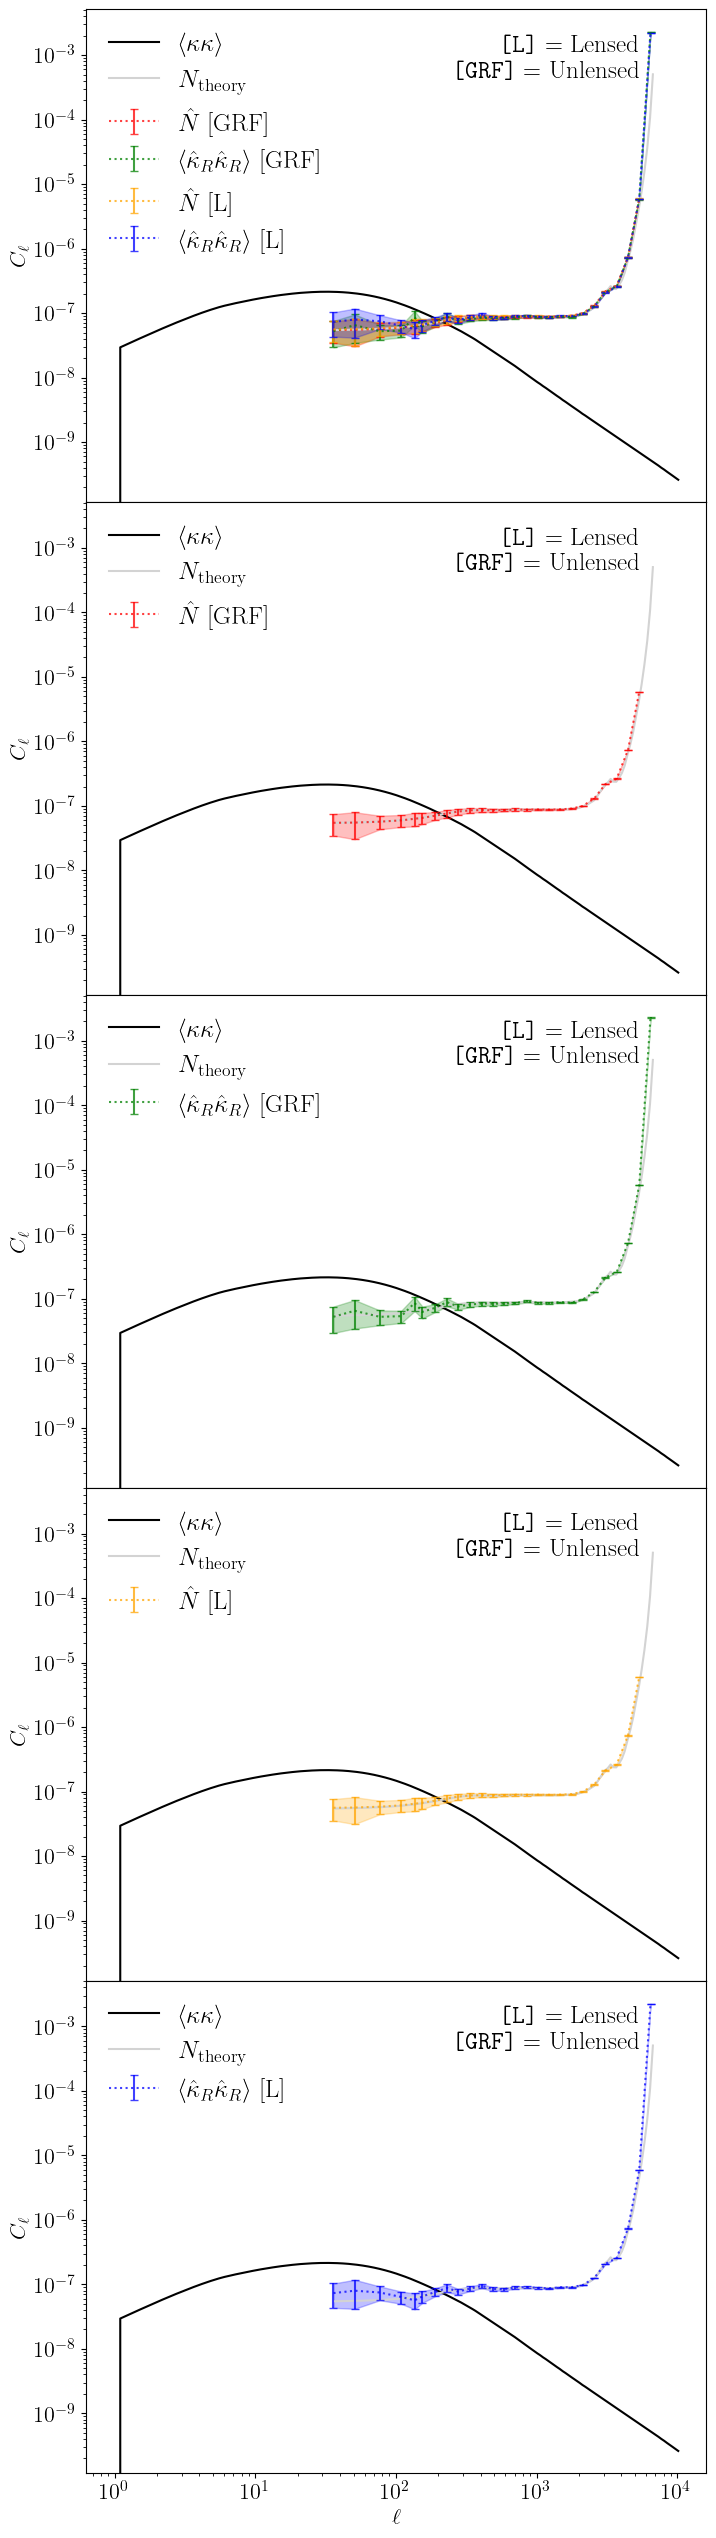

In [115]:
#Look at N0 Biases
fig, axs = plt.subplots(nrows=5, figsize=(8,32), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
ell = baseMap.l.flatten()

Ntheory = lambda l: fNqCmb_fft(l) #+ fNqCmbFG_fft(l)
theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax in axs:
        ax.plot(L, ClExpected, sty, label=l)


c_keys = [
    'Nhat0_0',
    'kRkR0_0',
    'Nhat0_1',
    'kRkR0_1',
]

col = dict(zip(c_keys, [
    'r',
    'g',
    'orange',
    'b'
]))

labels = dict(zip(c_keys, [
    r'$\hat N$ [GRF]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>$ [GRF]',
    r'$\hat N$ [L]',
    r'$\left<\hat\kappa_R\hat\kappa_R\right>$ [L]',
]))
idxs = dict(zip(c_keys,
               [
                   [0 ,1],
                   [0, 2],
                   [0, 3],
                   [0, 4]
               ]))
print('plotting data')

def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

for key in c_keys:
    lCen, Cl, sCl = combine_Cl(np.array(data[key]))
    
    Ipos = np.where(Cl>=1e-10)

    for idx in idxs[key]:
    
        ax = axs[idx]

        ax.errorbar(lCen[Ipos], (Cl[Ipos]), 
                    yerr=sCl[Ipos], c=col[key], 
                    alpha=.75, fmt=':', 
                    capsize=3, label=labels[key], capthick=1)

        tmp_data = {
           'x': lCen[Ipos],
           'y1': [y - e for y, e in zip(Cl[Ipos], sCl[Ipos])],
           'y2': [y + e for y, e in zip(Cl[Ipos], sCl[Ipos])]}
        ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    

for ax in axs:
    l=ax.legend(frameon=False, loc='upper left')
    s = r'\texttt{[L]} = Lensed'
    s += '\n'
    s += r'\texttt{[GRF]} = Unlensed'
    ax.text(.90, .95,
       s=s,
       transform=ax.transAxes,
       horizontalalignment='right',
       verticalalignment='top',
      fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$C_\ell$')
# plt.savefig( 
# 'figures/N0_unmasked.pdf',
#     bbox_inches='tight'
# )

5 (5, 3, 50)


(1e-10, 0.01)

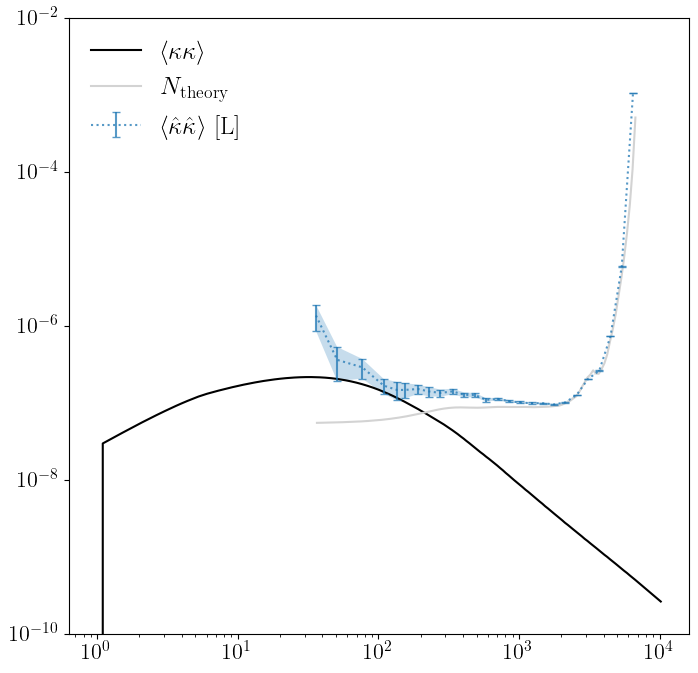

In [111]:
fig, axs = plt.subplots(nrows=1, figsize=(8,8), sharey=True)
ax = axs


theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))

    ax.plot(L, ClExpected, sty, label=l)


        
lCen, Cl, sCl = combine_Cl(data['kk1_1'])


ax.errorbar(lCen[Ipos], (Cl[Ipos]), 
            yerr=sCl[Ipos], 
            alpha=.75, fmt=':', 
            capsize=3, capthick=1,
           label=r'$\left<\hat\kappa\hat\kappa\right>$ [L]'
           )

tmp_data = {
   'x': lCen[Ipos],
   'y1': [y - e for y, e in zip(Cl[Ipos], sCl[Ipos])],
   'y2': [y + e for y, e in zip(Cl[Ipos], sCl[Ipos])]}
ax.fill_between(**tmp_data,  alpha=.25)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-10,1e-2)

(100, 3, 50)
(100, 3, 50)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ...  1. nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
0.3202453542993433
100 (100, 3, 50)


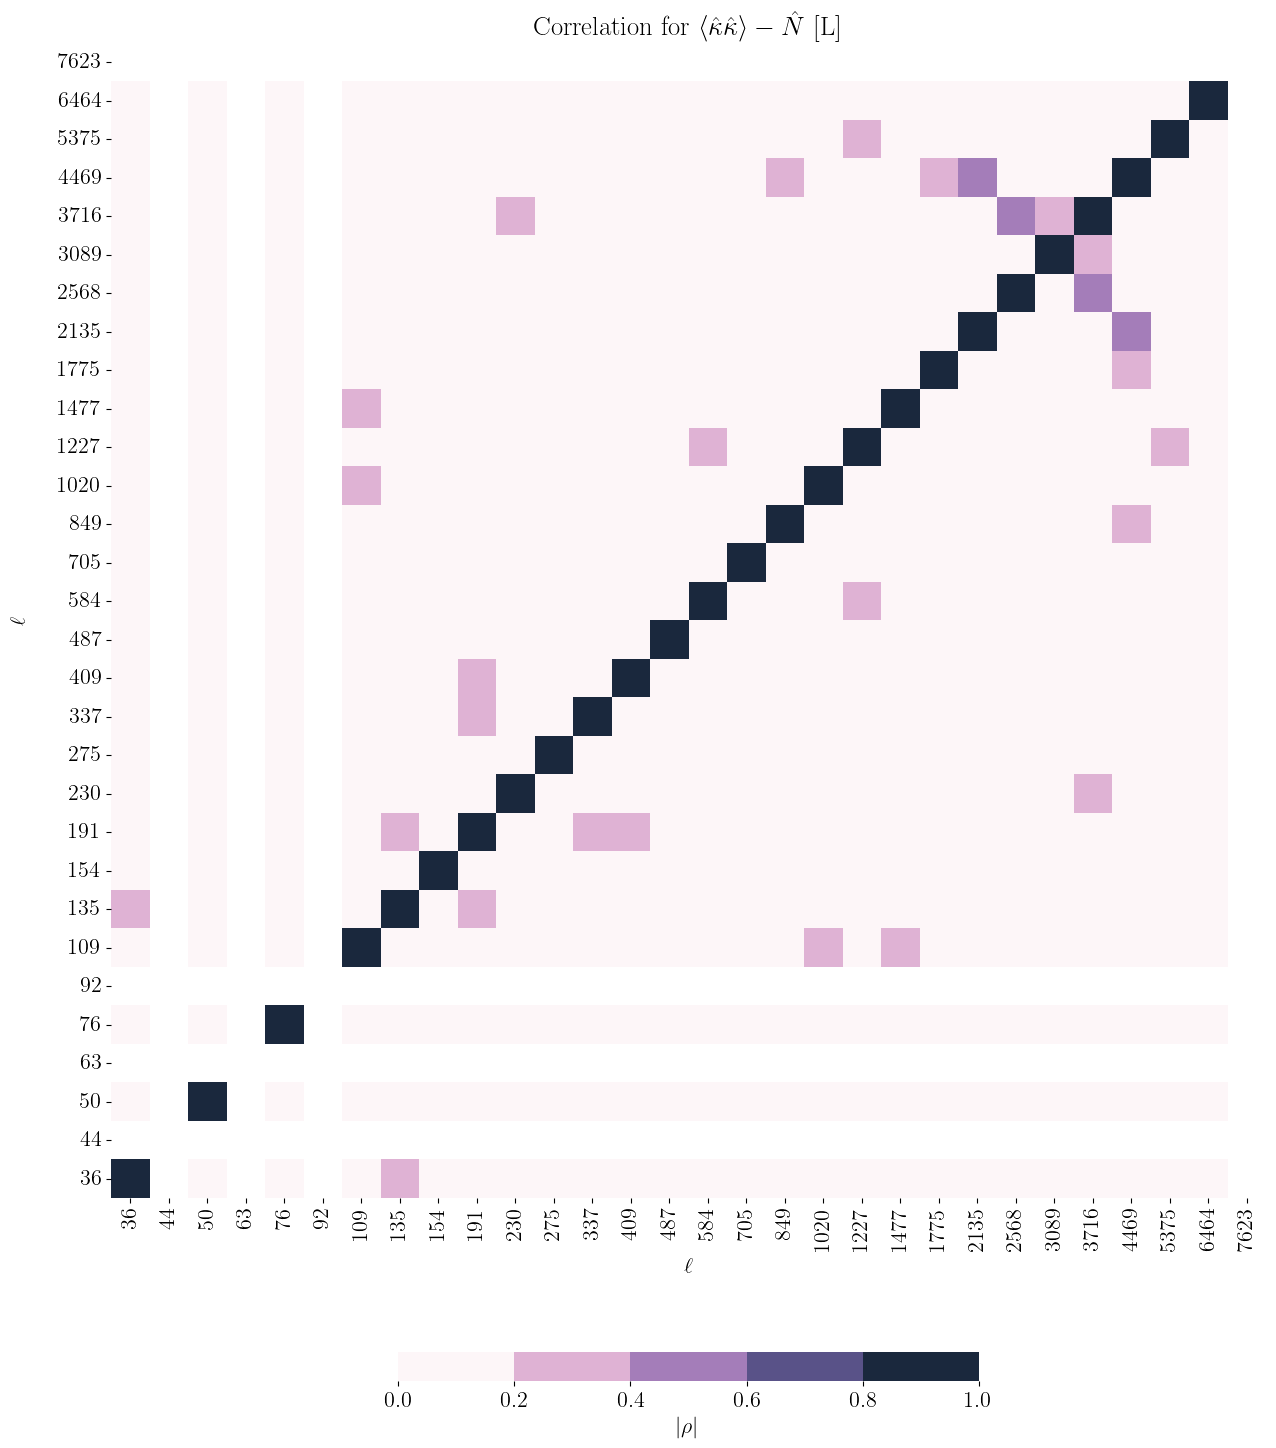

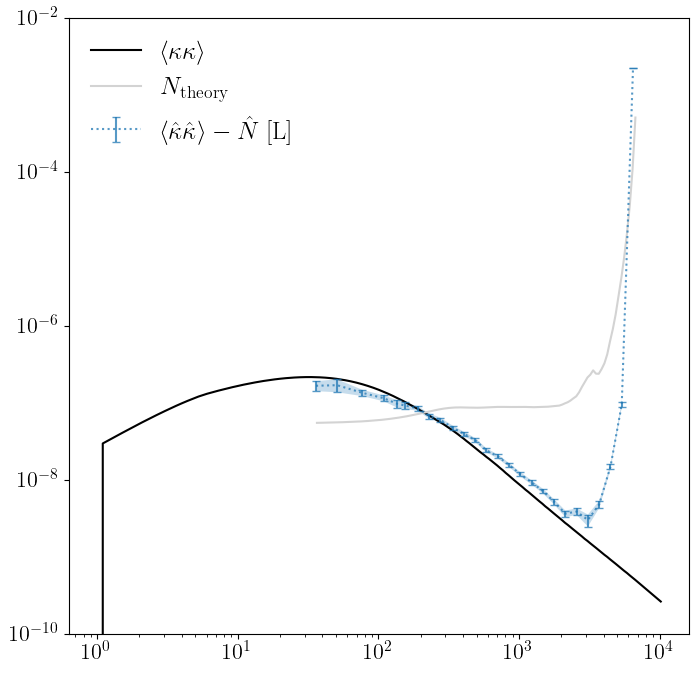

In [86]:
from scipy.stats import spearmanr
import seaborn as sns
cmap =sns.cubehelix_palette(start=26/10, light=.97, n_colors=5)

# 'kk0_1'
# 'Nhat0_1'

print(np.shape(data['kk0_1']))
print(np.shape(data['Nhat0_1']))

Cls_tmp = np.transpose(np.copy(data['kk0_1']), axes=[1,2,0])
Cls_tmp[1] -= np.transpose(data['Nhat0_1'], axes=[1,2,0])[1]
corr_nhat = np.array([[np.abs(np.corrcoef(Cls_tmp[1][i1], Cls_tmp[1][i2])[1,0])
                      for i1 in range(len(Cls_tmp[1]))]
                     for i2 in range(len(Cls_tmp[1]))])
print(corr_nhat)

print(np.corrcoef(Cls_tmp[1][43],Cls_tmp[1][44])[1,0])

ls = data['kk0_1'][0][0]
ll = ['%d'%l for l in ls]

plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 16

plt.figure(figsize=(25,20))
ax = sns.heatmap(corr_nhat, cmap=cmap, cbar=True, vmin=0, vmax=1, square=True,
                cbar_kws={'label': r"$|\rho|$", 
                          "orientation": "horizontal", 'pad':0.1, 'shrink':0.3})

ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
plt.xlabel(r'$\ell$'+'\n')



ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
plt.ylabel(r'$\ell$'+'\n')

plt.title(r'Correlation for $\left<\hat\kappa\hat\kappa\right>-\hat N$ [L]')
plt.xlim(19, 49)
plt.ylim(19, 49)

plt.savefig('figures/corr_kk_nhat.pdf', bbox_inches='tight')




fig, axs = plt.subplots(nrows=1, figsize=(8,8), sharey=True)
ax = axs


theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))

    ax.plot(L, ClExpected, sty, label=l)


        
Cls_tmp =  np.transpose(Cls_tmp, axes=[2,0,1])
lCen, Cl, sCl = combine_Cl(Cls_tmp)


ax.errorbar(lCen[Ipos], (Cl[Ipos]), 
            yerr=sCl[Ipos], 
            alpha=.75, fmt=':', 
            capsize=3, capthick=1,
           label=r'$\left<\hat\kappa\hat\kappa\right>-\hat N$ [L]'
           )

tmp_data = {
   'x': lCen[Ipos],
   'y1': [y - e for y, e in zip(Cl[Ipos], sCl[Ipos])],
   'y2': [y + e for y, e in zip(Cl[Ipos], sCl[Ipos])]}
ax.fill_between(**tmp_data,  alpha=.25)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-10,1e-2)
plt.savefig('figures/Cl_kk_nhat.pdf', bbox_inches='tight')



[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ...  1. nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
0.43155172127751124
100 (100, 3, 50)


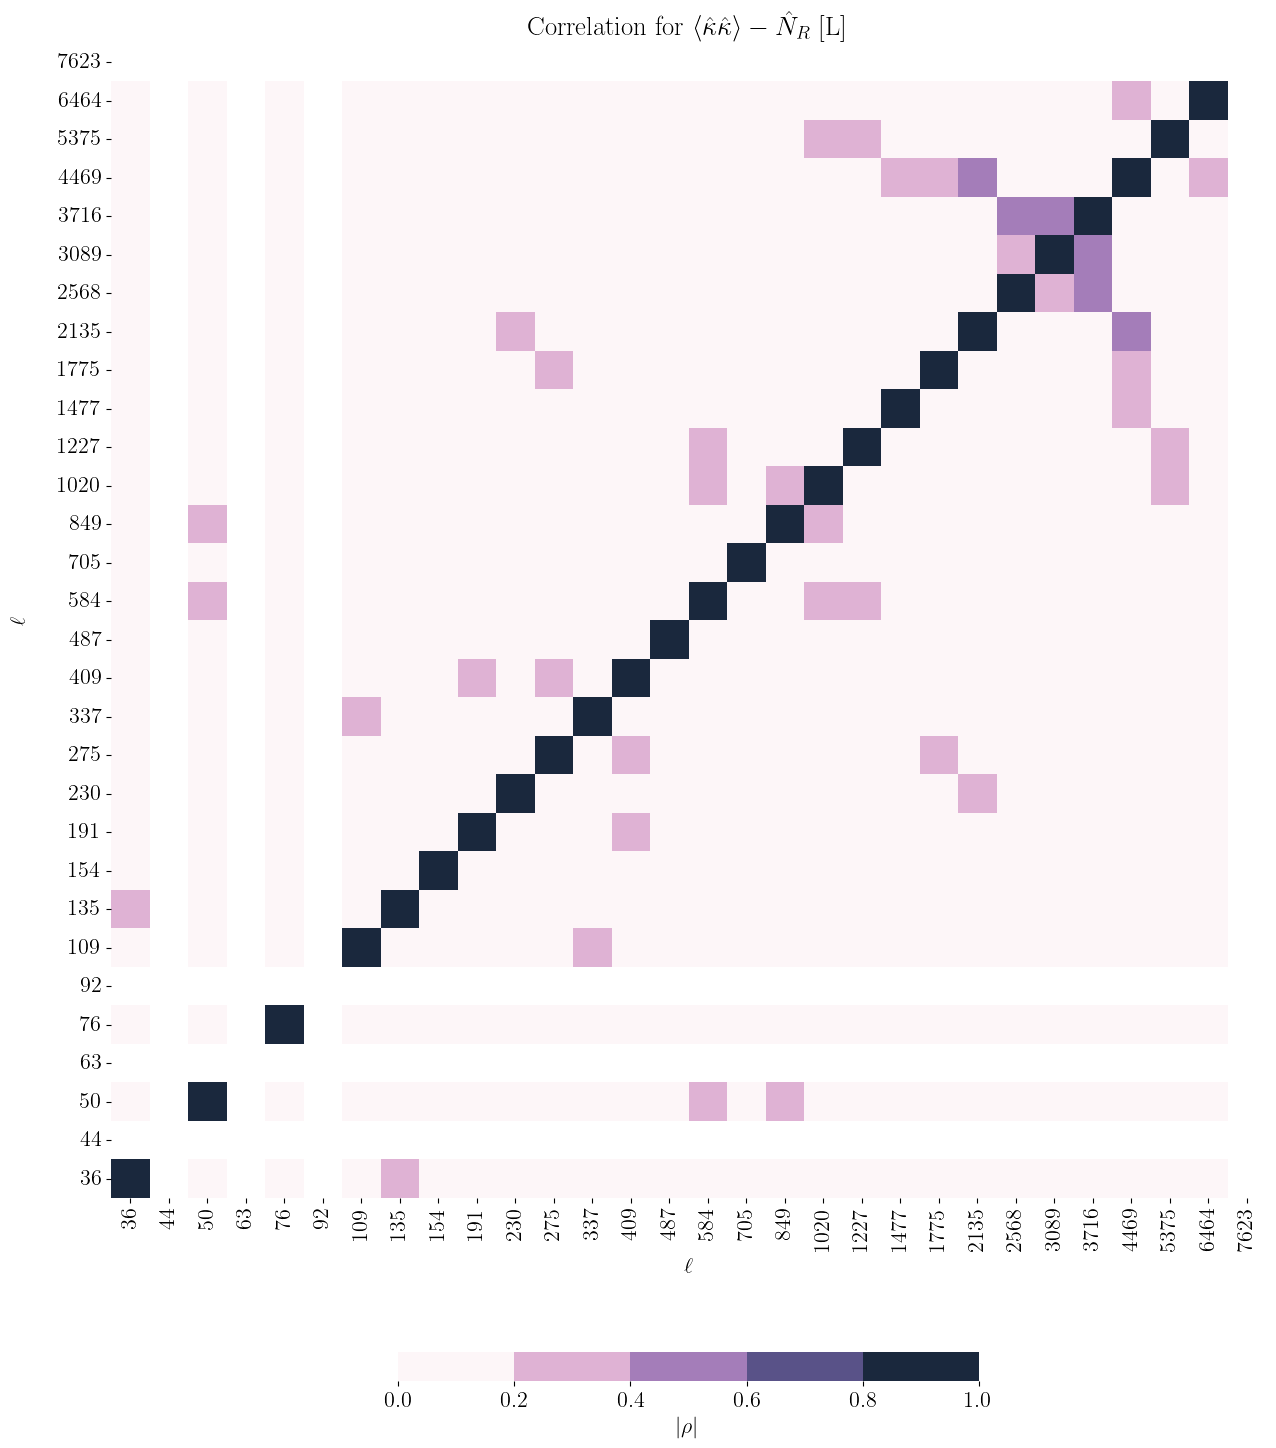

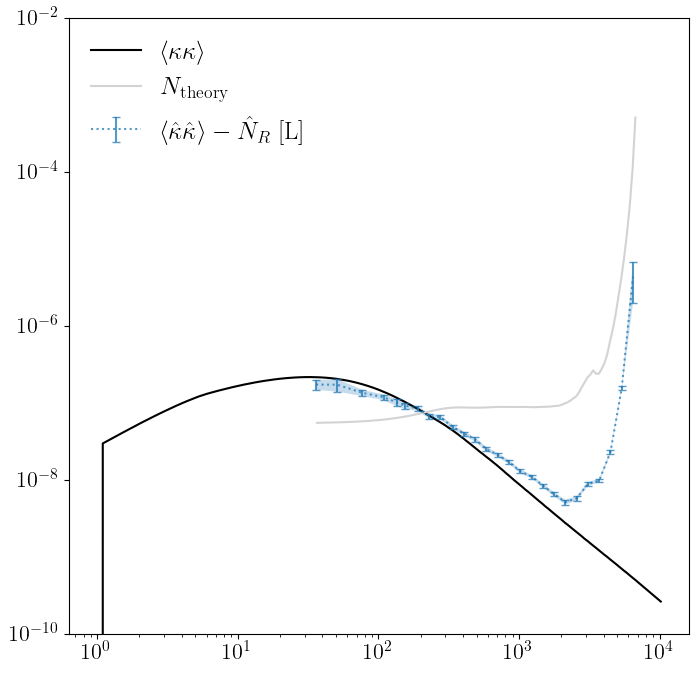

In [87]:
from scipy.stats import spearmanr
import seaborn as sns
cmap =sns.cubehelix_palette(start=26/10, light=.97, n_colors=5)



Cls_tmp = np.transpose(np.copy(data['kk0_1']), axes=[1,2,0])
Cls_tmp[1] -= np.transpose(data['kRkR0_1'], axes=[1,2,0])[1]
corr_nhat = np.array([[np.abs(np.corrcoef(Cls_tmp[1][i1], Cls_tmp[1][i2])[1,0])
                      for i1 in range(len(Cls_tmp[1]))]
                     for i2 in range(len(Cls_tmp[1]))])
print(corr_nhat)

print(np.corrcoef(Cls_tmp[1][43],Cls_tmp[1][44])[1,0])

ls = data['kk0_1'][0][0]
ll = ['%d'%l for l in ls]

plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 16

plt.figure(figsize=(25,20))
ax = sns.heatmap(corr_nhat, cmap=cmap, cbar=True, vmin=0, vmax=1, square=True,
                cbar_kws={'label': r"$|\rho|$", 
                          "orientation": "horizontal", 'pad':0.1, 'shrink':0.3})

ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
plt.xlabel(r'$\ell$'+'\n')



ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
plt.ylabel(r'$\ell$'+'\n')

plt.title(r'Correlation for $\left<\hat\kappa\hat\kappa\right>-\hat N_R$ [L]')
plt.xlim(19, 49)
plt.ylim(19, 49)

plt.savefig('figures/corr_kk_nR.pdf', bbox_inches='tight')




fig, axs = plt.subplots(nrows=1, figsize=(8,8), sharey=True)
ax = axs


theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))

    ax.plot(L, ClExpected, sty, label=l)


        
Cls_tmp =  np.transpose(Cls_tmp, axes=[2,0,1])
lCen, Cl, sCl = combine_Cl(Cls_tmp)


ax.errorbar(lCen[Ipos], (Cl[Ipos]), 
            yerr=sCl[Ipos], 
            alpha=.75, fmt=':', 
            capsize=3, capthick=1,
            label=r'$\left<\hat\kappa\hat\kappa\right>-\hat N_R$ [L]')

tmp_data = {
   'x': lCen[Ipos],
   'y1': [y - e for y, e in zip(Cl[Ipos], sCl[Ipos])],
   'y2': [y + e for y, e in zip(Cl[Ipos], sCl[Ipos])]}
ax.fill_between(**tmp_data,  alpha=.25)
ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim(1e-10,1e-2)


plt.savefig('figures/Cl_kk_nR.pdf', bbox_inches='tight')


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ...  1. nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
0.7981045710860238
100 (100, 3, 50)


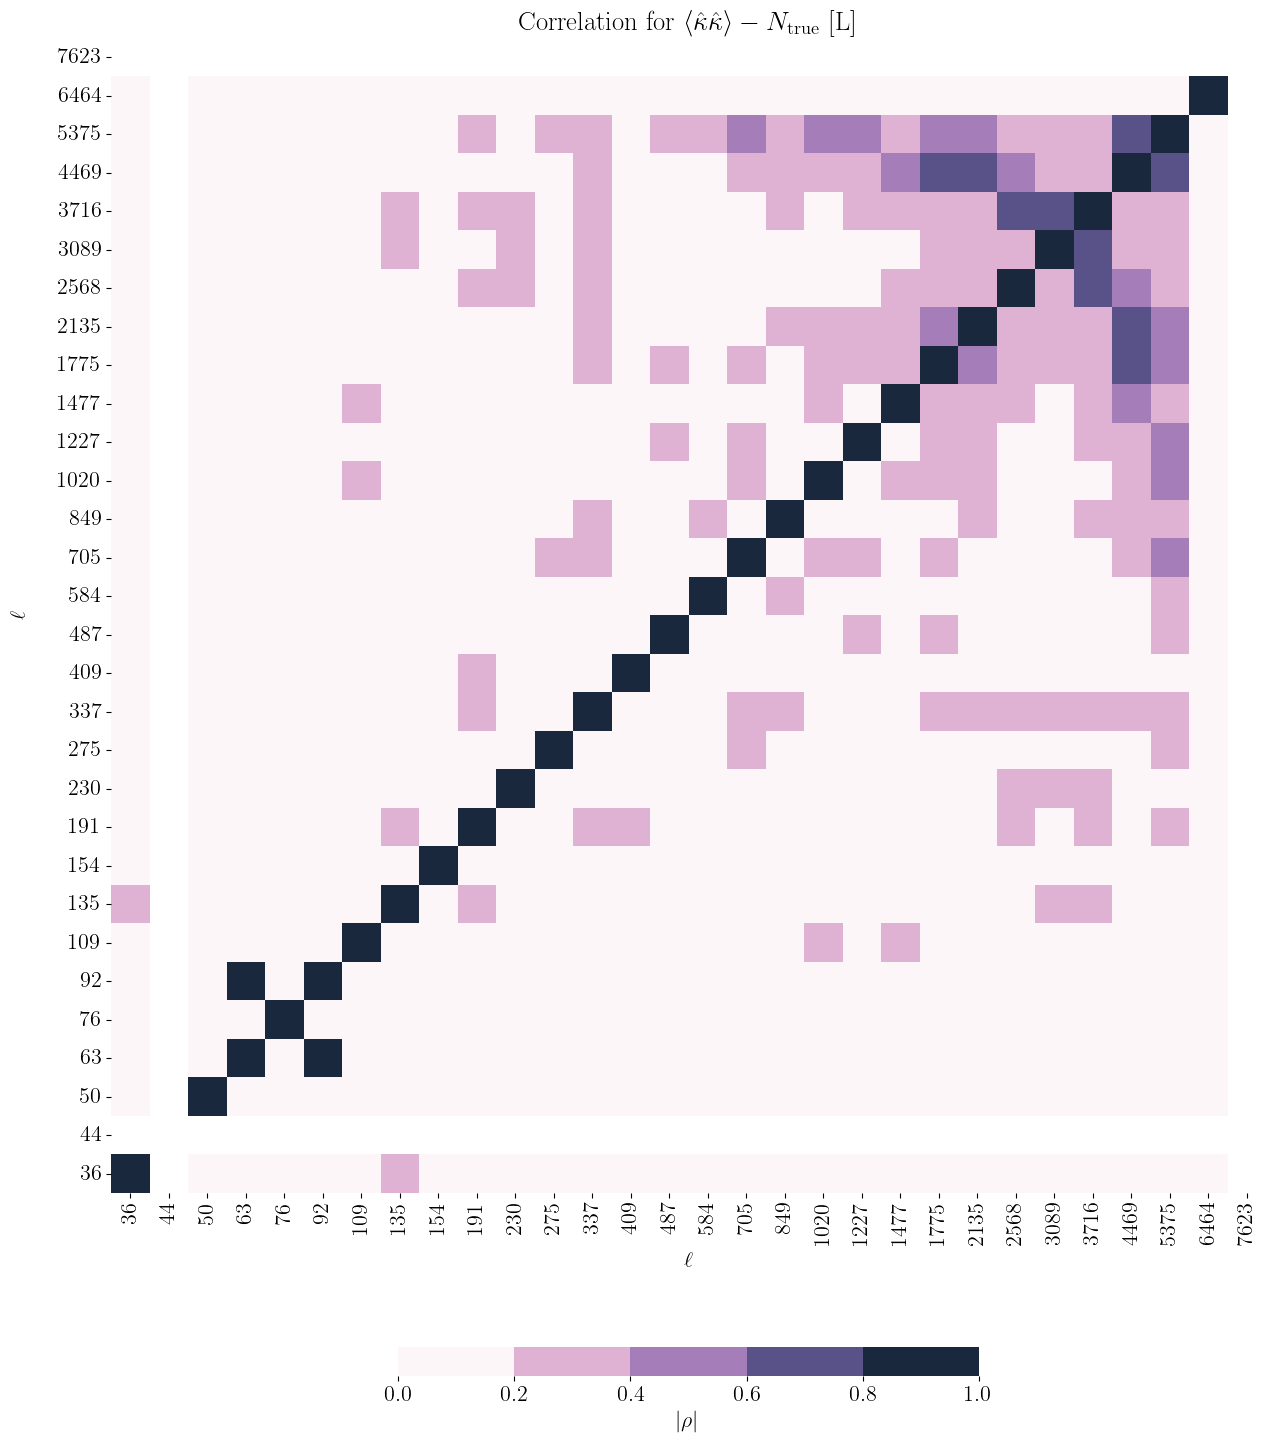

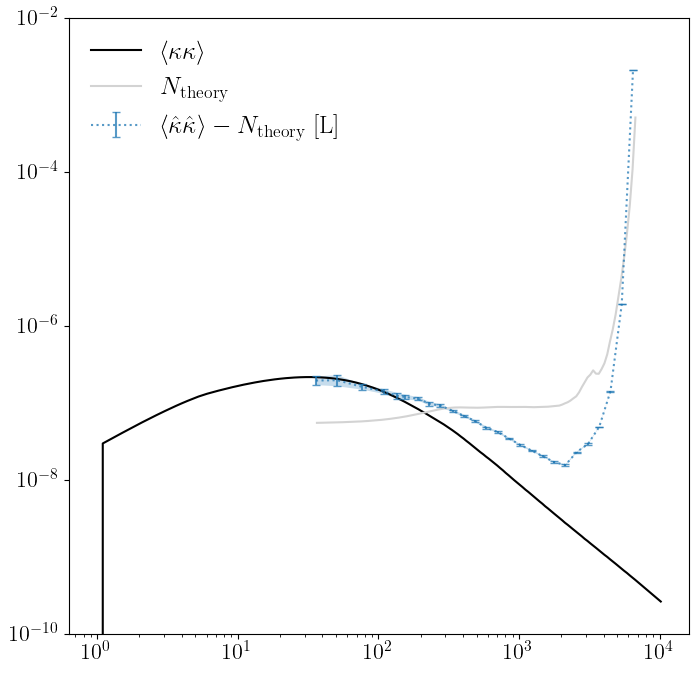

In [93]:
from scipy.stats import spearmanr
import seaborn as sns
cmap =sns.cubehelix_palette(start=26/10, light=.97, n_colors=5)

ls = data['kk0_1'][0][0]
ll = ['%d'%l for l in ls]


Cls_tmp = np.transpose(np.copy(data['kk0_1']), axes=[1,2,0])


Cls_tmp[1] -= np.transpose([[Ntheory(l) for l in ls] for _ in range(len(data['kk0_1']))])
corr_nhat = np.array([[np.abs(np.corrcoef(Cls_tmp[1][i1], Cls_tmp[1][i2])[1,0])
                      for i1 in range(len(Cls_tmp[1]))]
                     for i2 in range(len(Cls_tmp[1]))])
print(corr_nhat)

print(np.corrcoef(Cls_tmp[1][43],Cls_tmp[1][44])[1,0])


plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 16

plt.figure(figsize=(25,20))
ax = sns.heatmap(corr_nhat, cmap=cmap, cbar=True, vmin=0, vmax=1, square=True,
                cbar_kws={'label': r"$|\rho|$", 
                          "orientation": "horizontal", 'pad':0.1, 'shrink':0.3})

ax.tick_params(axis=u'x', which=u'both',labelrotation=90)
ax.set_xticks(np.arange(len(ll))+0.5, labels=ll)
plt.xlabel(r'$\ell$'+'\n')



ax.tick_params(axis=u'y', which=u'both',labelrotation=0)
ax.set_yticks(np.arange(len(ll))+0.5, labels=ll)
plt.ylabel(r'$\ell$'+'\n')

plt.title(r'Correlation for $\left<\hat\kappa\hat\kappa\right>-N_{\rm true}$ [L]')
plt.xlim(19, 49)
plt.ylim(19, 49)

plt.savefig('figures/corr_kk_n.pdf', bbox_inches='tight')




fig, axs = plt.subplots(nrows=1, figsize=(8,8), sharey=True)
ax = axs


theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))

    ax.plot(L, ClExpected, sty, label=l)


        
Cls_tmp =  np.transpose(Cls_tmp, axes=[2,0,1])
lCen, Cl, sCl = combine_Cl(Cls_tmp)


ax.errorbar(lCen[Ipos], (Cl[Ipos]), 
            yerr=sCl[Ipos], 
            alpha=.75, fmt=':', 
            capsize=3, capthick=1,
            label=r'$\left<\hat\kappa\hat\kappa\right>-N_{\rm theory}$ [L]')


tmp_data = {
   'x': lCen[Ipos],
   'y1': [y - e for y, e in zip(Cl[Ipos], sCl[Ipos])],
   'y2': [y + e for y, e in zip(Cl[Ipos], sCl[Ipos])]}
ax.fill_between(**tmp_data,  alpha=.25)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-10,1e-2)

ax.legend(frameon=False)
plt.savefig('figures/Cl_kk_n.pdf', bbox_inches='tight')




In [22]:

for key in data:
    if(np.shape(data[key])[1]!=3):
        continue
    print(key)

Nhat0_1
kRkR0_1
kk0_1
kTkT0_1
Nhat0_0
kRkR0_0
kk0_0


plotting data
100 (100, 3, 50)
100 (100, 3, 50)


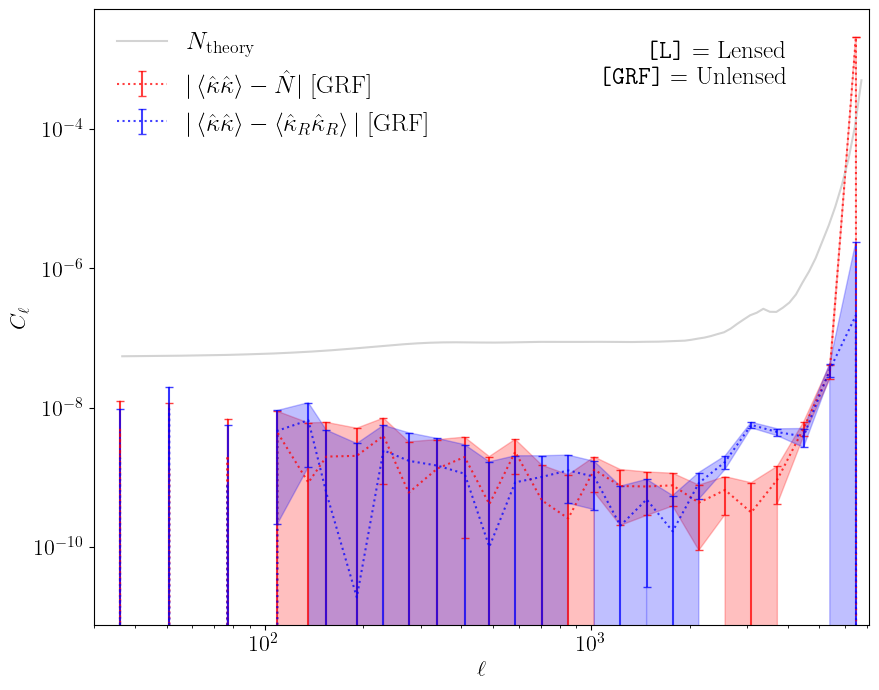

In [94]:
fig, axs = plt.subplots(nrows=1, figsize=(10,8), sharey=True)
axs=[axs]
fig.subplots_adjust(wspace=0, hspace=0)
ell = baseMap.l.flatten()

theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    if('black'==sty):
        continue
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax in axs:
        ax.plot(L, ClExpected, sty, label=l)


c_keys = [
    'Nhat0_0',
    'kRkR0_0',
#     'Nhat0_1',
#     'kRkR0_1',
]

col = dict(zip(c_keys, [
    'r',
    'b',
    'orange',
    'b'
]))

labels = dict(zip(c_keys, [
    r'$|\left<\hat\kappa\hat\kappa\right> - \hat N|$ [GRF]',
    r'$|\left<\hat\kappa\hat\kappa\right> - \left<\hat\kappa_R\hat\kappa_R\right>|$ [GRF]',
    r'$\left<\hat\kappa\hat\kappa\right> - \hat N$ [L]',
    r'$\left<\hat\kappa\hat\kappa\right> - \left<\hat\kappa_R\hat\kappa_R\right>$ [L]',
]))
print('plotting data')

idxs = dict(zip(c_keys,
               [
                   [0],
                   [0],
                   [1],
                   [1]
               ]))

for key in c_keys:
    tmp_postfix = (key.split('_'))
    c_postfix = tmp_postfix[0][-1]+'_'+tmp_postfix[1]
    
    Cls_tmp = np.transpose(np.copy(data['kk'+c_postfix]), axes=[1,2,0])
    Cls_tmp[1] -= np.transpose(data[key], axes=[1,2,0])[1]
    Cls_tmp = np.transpose(Cls_tmp, axes=[2,0,1])
    
    lCen, Cl, sCl = combine_Cl(Cls_tmp)

    Ipos = np.where(Cl>=1e-30)

    for idx in idxs[key]:
    
        ax = axs[idx]

        ax.errorbar(lCen, np.abs(Cl), 
                    yerr=sCl, c=col[key], 
                    alpha=.75, fmt=':', 
                    capsize=3, label=labels[key], capthick=1)

        tmp_data = {
           'x': lCen,
           'y1': [y - e for y, e in zip(np.abs(Cl), sCl)],
           'y2': [y + e for y, e in zip(np.abs(Cl), sCl)]}
        ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    

for ax in axs:
    l=ax.legend(frameon=False, loc='upper left')
    s = r'\texttt{[L]} = Lensed'
    s += '\n'
    s += r'\texttt{[GRF]} = Unlensed'
    ax.set_xlim(lMin,2*lMax+100)
    ax.text(.90, .95,
       s=s,
       transform=ax.transAxes,
       horizontalalignment='right',
       verticalalignment='top',
      fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$C_\ell$')
plt.savefig(
'figures/Cl_unlensed.pdf',
    bbox_inches='tight'
)

plotting data
100 (100, 3, 50)
100 (100, 3, 50)


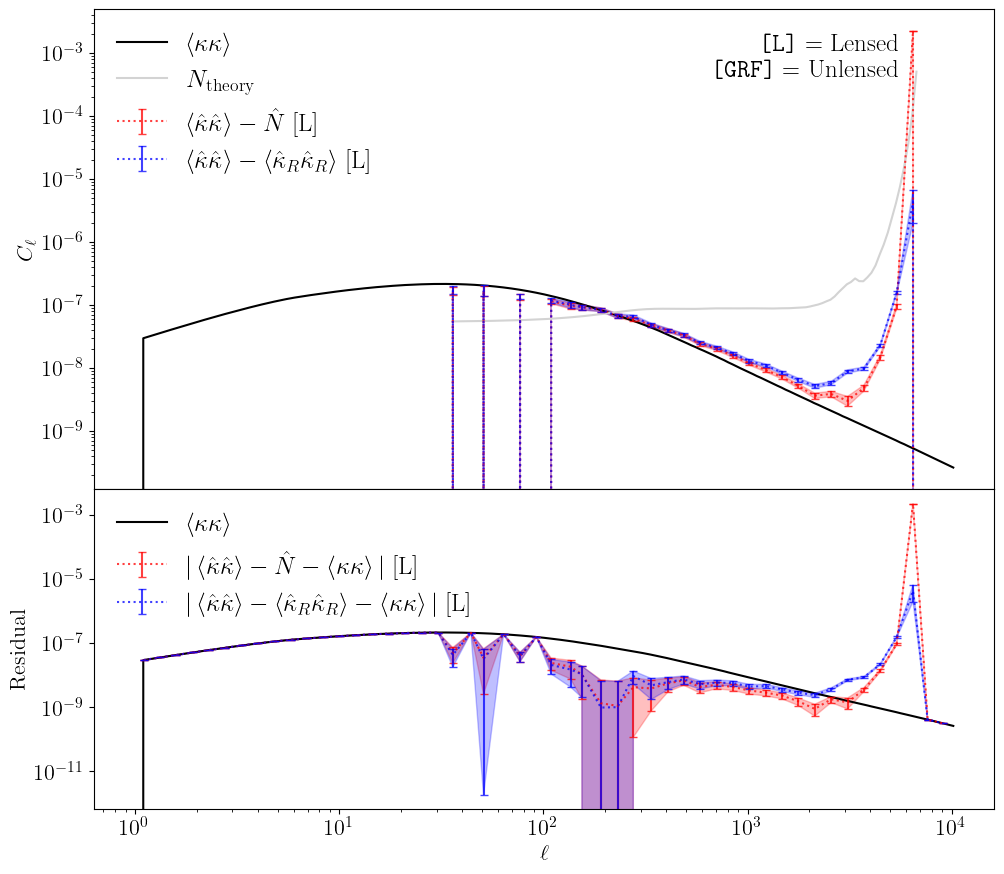

In [95]:
fig1 = plt.figure(figsize =(12, 8))

axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]

# fig.subplots_adjust(wspace=0, hspace=0)
ell = baseMap.l.flatten()

theory=[p2d_cmblens.fPinterp, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    for ax_idx in range(len(axs)):
        ax = axs[ax_idx]
        if(ax_idx==1 and sty=='lightgrey'):
            continue
        ax.plot(L, ClExpected, sty, label=l)


c_keys = [
    'Nhat0_1',
    'kRkR0_1',
]

col = dict(zip(c_keys, [
    'r',
    'b',
]))

labels = dict(zip(c_keys, [
    r'$\left<\hat\kappa\hat\kappa\right> - \hat N$ [L]',
    r'$\left<\hat\kappa\hat\kappa\right> - \left<\hat\kappa_R\hat\kappa_R\right>$ [L]',
]))

aux_labels = dict(zip(c_keys, [
    r'$|\left<\hat\kappa\hat\kappa\right> - \hat N - \left<\kappa\kappa\right>|$ [L]',
    r'$|\left<\hat\kappa\hat\kappa\right> - \left<\hat\kappa_R\hat\kappa_R\right> - \left<\kappa\kappa\right>|$ [L]',
]))
print('plotting data')

idxs = dict(zip(c_keys,
               [
                   [0],
                   [0],
               ]))

for key in c_keys:
    tmp_postfix = (key.split('_'))
    c_postfix = tmp_postfix[0][-1]+'_'+tmp_postfix[1]
    
    Cls_tmp = np.transpose(np.copy(data['kk'+c_postfix]), axes=[1,2,0])
    Cls_tmp[1] -= np.transpose(data[key], axes=[1,2,0])[1]
    Cls_tmp = np.transpose(Cls_tmp, axes=[2,0,1])
    
    lCen, Cl, sCl = combine_Cl(Cls_tmp)

    Ipos = np.where(Cl>=1e-30)

    
    ax = axs[0]

    ax.errorbar(lCen, (Cl), 
                yerr=sCl, c=col[key], 
                alpha=.75, fmt=':', 
                capsize=3, label=labels[key], capthick=1)

    tmp_data = {
       'x': lCen,
       'y1': [y - e for y, e in zip((Cl), sCl)],
       'y2': [y + e for y, e in zip((Cl), sCl)]}
    ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    
    
    Cl_res = Cl - np.array(list(map(p2d_cmblens.fPinterp, lCen)))
    ax = axs[1]

    ax.errorbar(lCen, np.abs(Cl_res), 
                yerr=sCl, c=col[key], 
                alpha=.75, fmt=':', 
                capsize=3, label=aux_labels[key], capthick=1)

    tmp_data = {
       'x': lCen,
       'y1': [y - e for y, e in zip(np.abs(Cl_res), sCl)],
       'y2': [y + e for y, e in zip(np.abs(Cl_res), sCl)]}
    ax.fill_between(**tmp_data, color=col[key], alpha=.25)
    
    ax.set_ylabel(r'Residual')

    
axs[1].axhline(0, linewidth=1, linestyle="--", color="black")
for ax_idx in range(len(axs)):
    ax = axs[ax_idx]
    l=ax.legend(frameon=False, loc='upper left')
    ax.set_xscale('log')
    ax.set_xlabel(r'$\ell$')
    ax.set_yscale('log')
    ax.set_xlim(0)
    if(ax_idx==1):
        continue

    s = r'\texttt{[L]} = Lensed'
    s += '\n'
    s += r'\texttt{[GRF]} = Unlensed'
    ax.text(.90, .95,
       s=s,
       transform=ax.transAxes,
       horizontalalignment='right',
       verticalalignment='top',
      fontsize=18)
    ax.set_ylabel(r'$C_\ell$')
plt.savefig(
'figures/Cl_lensed.pdf',
    bbox_inches='tight'
)